In [3]:
import numpy as np
#import tensorflow as tf
from tensorflow.keras import layers, Model
from ccnn import CConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import matplotlib.pyplot as plt

In [4]:
#DATA FOR 6000 RECEIVERS training + 3000 RECEIVERS second scenario + 1000 RECEIVERS predict
import numpy as np
base = "..\\..\\..\\..\\FlandersTraining\\"
output_features_def1 = np.load(base+"output_features_def1-1000PBF_sc1.npy")
input_data1 = np.load(base+"input_data1-1000PBF_sc1.npy")
output_features_def2 = np.load(base+"output_features_def1001-2000PBF_sc1.npy")
input_data2 = np.load(base+"input_data1001-2000PBF_sc1.npy")
output_features_def3 = np.load(base+"output_features_def2001-3000PBF_sc1.npy")
input_data3 = np.load(base+"input_data2001-3000PBF_sc1.npy")
output_features_def4 = np.load(base+"output_features_def4001-5000PBF_sc1.npy")
input_data4 = np.load(base+"input_data4001-5000PBF_sc1.npy")
output_features_def5 = np.load(base+"output_features_def5001-6000PBF_sc1.npy")
input_data5 = np.load(base+"input_data5001-6000PBF_sc1.npy")
output_features_def6 = np.load(base+"output_features_def3001-4000PBF_sc2.npy")
input_data6 = np.load(base+"input_data3001-4000PBF_sc2.npy")
output_features_def7 = np.load(base+"output_features_def1001-2000PBF_sc2.npy")
input_data7 = np.load(base+"input_data1001-2000PBF_sc2.npy")
output_features_def8 = np.load(base+"output_features_def2001-3000PBF_sc2.npy")
input_data8 = np.load(base+"input_data2001-3000PBF_sc2.npy")
output_features_def9 = np.load(base+"output_features_def6001-7000PBF_sc1.npy")
input_data9 = np.load(base+"input_data6001-7000PBF_sc1.npy")
output_features_def10 = np.load(base+"output_features_def4001-5000PBF_sc2.npy")
input_data10 = np.load(base+"input_data4001-5000PBF_sc2.npy")
#output_features_def10 = np.load(base+"output_features_def5001-6000PBF_sc2.npy")
#input_data10 = np.load(base+"input_data5001-6000PBF_sc2.npy")

output_features_test1 = np.load(base+"output_features_def3001-4000PBF_sc1.npy")
input_data_test1 = np.load(base+"input_data3001-4000PBF_sc1.npy")
output_features_test2 = np.load(base+"output_features_def400-1000PBF_sc2.npy")
input_data_test2 = np.load(base+"input_data400-1000PBF_sc2.npy")
input_data = np.concatenate([input_data1, input_data2, input_data3, input_data4, input_data5, input_data6, input_data7, input_data8, input_data9, input_data10])
output_features_def = np.concatenate([output_features_def1,output_features_def2, output_features_def3, output_features_def4, output_features_def5, output_features_def6, output_features_def7, output_features_def8, output_features_def9, output_features_def10])
input_data_test = np.concatenate([input_data_test1,input_data_test2])
output_features_test = np.concatenate([output_features_test1,output_features_test2])
print(input_data.shape)
print(output_features_def.shape)
print(input_data_test.shape)
print(output_features_test.shape)

(38176, 452)
(38176, 17)
(6216, 452)
(6216, 17)


In [5]:
# try a more clever scaler with mean and stdev on each group of features
# reorganise the data such that all features of the same type are grouped
# refer to the document ML_input_indicator_range.xlsx on sharepoint for range definitions

class GroupScaler:
    def __init__(self):
        self.inputscalers = []
    
    def fit(self, samples): 
        Nsamples = samples.shape[0]
        samples_reordered = []
        #building densities
        samples_reordered.append(np.reshape(samples[:,0:36],(36*Nsamples,)))
        #distances within 200m
        samples_reordered.append(np.reshape(samples[:,36:432],(((432-36)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,432])
        #road length
        samples_reordered.append(np.reshape(samples[:,433:437],(((437-433)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,437])
        #road length
        samples_reordered.append(np.reshape(samples[:,438:442],(((442-438)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,442])
        #road length
        samples_reordered.append(np.reshape(samples[:,443:447],(((447-443)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,447])
        #road length
        samples_reordered.append(np.reshape(samples[:,448:452],(((452-448)*Nsamples,))))

        # now create separate scalers for each group
        for input_d in range(0,len(samples_reordered)): 
            self.inputscalers.append(StandardScaler(with_mean=False))
            self.inputscalers[input_d].fit(samples_reordered[input_d].reshape(-1,1))
    
    def transform(self, samples):
        Nsamples = samples.shape[0]
        samples_reordered = []
        #building densities
        samples_reordered.append(np.reshape(samples[:,0:36],(36*Nsamples,)))
        #distances within 200m
        samples_reordered.append(np.reshape(samples[:,36:432],(((432-36)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,432])
        #road length
        samples_reordered.append(np.reshape(samples[:,433:437],(((437-433)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,437])
        #road length
        samples_reordered.append(np.reshape(samples[:,438:442],(((442-438)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,442])
        #road length
        samples_reordered.append(np.reshape(samples[:,443:447],(((447-443)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,447])
        #road length
        samples_reordered.append(np.reshape(samples[:,448:452],(((452-448)*Nsamples,))))

        # now apply separate scalers for each group
        scaled_reordered = []
        for input_d in range(0,len(samples_reordered)): 
            scaled_reordered.append(self.inputscalers[input_d].transform(samples_reordered[input_d].reshape(-1,1)))
        
        # restore original sample
        scaled = np.zeros((Nsamples,452))
        #building densities
        scaled[:,0:36] = np.reshape(scaled_reordered[0],(Nsamples,36))
        #distances within 200m
        scaled[:,36:432] = np.reshape(scaled_reordered[1],(Nsamples,(432-36)))
        #building density
        scaled[:,432] = scaled_reordered[2].reshape(-1,)
        #road length
        scaled[:,433:437] = np.reshape(scaled_reordered[3],(Nsamples,(437-433)))
        #building density
        scaled[:,437] = scaled_reordered[4].reshape(-1,)
        #road length
        scaled[:,438:442] = np.reshape(scaled_reordered[5],(Nsamples,(442-438)))
        #building density
        scaled[:,442] = scaled_reordered[6].reshape(-1,)
        #road length
        scaled[:,443:447] = np.reshape(scaled_reordered[7],(Nsamples,(447-443)))
        #building density
        scaled[:,447] = scaled_reordered[8].reshape(-1,)
        #road length
        scaled[:,448:452] = np.reshape(scaled_reordered[9],(Nsamples,(452-448)))
        
        return scaled
    
    def inverse_transform(self, samples):
        Nsamples = samples.shape[0]
        samples_reordered = []
        #building densities
        samples_reordered.append(np.reshape(samples[:,0:36],(36*Nsamples,)))
        #distances within 200m
        samples_reordered.append(np.reshape(samples[:,36:432],(((432-36)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,432])
        #road length
        samples_reordered.append(np.reshape(samples[:,433:437],(((437-433)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,437])
        #road length
        samples_reordered.append(np.reshape(samples[:,438:442],(((442-438)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,442])
        #road length
        samples_reordered.append(np.reshape(samples[:,443:447],(((447-443)*Nsamples,))))
        #building density
        samples_reordered.append(samples[:,447])
        #road length
        samples_reordered.append(np.reshape(samples[:,448:452],(((452-448)*Nsamples,))))

        # now apply separate scalers for each group
        scaled_reordered = []
        for input_d in range(0,len(samples_reordered)): 
            scaled_reordered.append(self.inputscalers[input_d].inverse_transform(samples_reordered[input_d].reshape(-1,1)))
        
        # restore original sample
        scaled = np.zeros((Nsamples,452))
        #building densities
        scaled[:,0:36] = np.reshape(scaled_reordered[0],(Nsamples,36))
        #distances within 200m
        scaled[:,36:432] = np.reshape(scaled_reordered[1],(Nsamples,(432-36)))
        #building density
        scaled[:,432] = scaled_reordered[2].reshape(-1,)
        #road length
        scaled[:,433:437] = np.reshape(scaled_reordered[3],(Nsamples,(437-433)))
        #building density
        scaled[:,437] = scaled_reordered[4].reshape(-1,)
        #road length
        scaled[:,438:442] = np.reshape(scaled_reordered[5],(Nsamples,(442-438)))
        #building density
        scaled[:,442] = scaled_reordered[6].reshape(-1,)
        #road length
        scaled[:,443:447] = np.reshape(scaled_reordered[7],(Nsamples,(447-443)))
        #building density
        scaled[:,447] = scaled_reordered[8].reshape(-1,)
        #road length
        scaled[:,448:452] = np.reshape(scaled_reordered[9],(Nsamples,(452-448)))
        
        return scaled


In [6]:
#Scale the values ??? do we need a new scaler with new traffic scenario
#import numpy as np
#from sklearn.preprocessing import StandardScaler
import pickle
#scaler_input = StandardScaler()
#scaler_input = pickle.load(open('CustomInputScalerPBF2.pkl','rb'))
scaler_input = pickle.load(open('CustomGroupInputScaler.pkl','rb'))
#scaler_output = StandardScaler()
scaler_output = pickle.load(open('CustomOutputScalerPBF2.pkl','rb'))

#print(scaler_input.fit(input_data))
#print(scaler_output.fit(output_features_def))
#print(scaler_input.mean_)
#print(scaler_output.mean_)
input_data_scaled = scaler_input.transform(input_data)
output_features_scaled = scaler_output.transform(output_features_def)
input_data_test_scaled = scaler_input.transform(input_data_test)
output_features_test_scaled = scaler_output.transform(output_features_test)

C:\Users\dbotteld\.conda\envs\ml_model_gpu\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
#Split data and validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(input_data_scaled, output_features_scaled, test_size=0.1, shuffle=True)
print(x_train.shape)
print(x_val.shape)

(34358, 452)
(3818, 452)


In [8]:
#ROTATE SCENARIO AND KEEP SAME OUTPUT VALUES (4 ROTATIONS)
nb_angles = 36
rotations = 6

rot = nb_angles//rotations
shape = x_train.shape
Input = np.zeros((rotations*shape[0], shape[1]))
Input[:shape[0]] = x_train
for i in range(rotations-1):
    for feature in range(12):
        x_train[:, feature*36:(feature+1)*36] = np.roll(x_train[:, feature*36:(feature+1)*36], rot, axis=1)
    Input[int((i+1)*shape[0]):int((i+2)*shape[0])] = x_train
for feature in range(12):
        x_train[:, feature*36:(feature+1)*36] = np.roll(x_train[:, feature*36:(feature+1)*36], rot, axis=1)

Output = np.tile(y_train, (rotations, 1))
print(Input.shape)
print(Output.shape)

(206148, 452)
(206148, 17)


In [9]:
#RUN THIS TO CREATE THE "IMAGES" AND THE DISTANCE DATA USED IN THE CNN MODEL
data_length = len(Input) 
test_length = len(input_data_test)
val_length = len(x_val)

imagedata = np.zeros([data_length,22,36])
imagedata_test = np.zeros([test_length, 22, 36])
imagedata_val = np.zeros([val_length, 22, 36])
for y in range(data_length):
    for j in range(22):
        i = j
        if j%2 == 1:
            i = 1
        elif j == 0:
            i = 0
        else:
            i = int(j/2)+1
        imagedata[y][j]=Input[y][0+(i*36):36+(i*36)]
for y in range(test_length):
    for j in range(22):
        i = j
        if j%2 == 1:
            i = 1
        elif j == 0:
            i = 0
        else:
            i = int(j/2)+1
        imagedata_test[y][j]=input_data_test_scaled[y][0+(i*36):36+(i*36)]
for y in range(val_length):
    for j in range(22):
        i = j
        if j%2 == 1:
            i = 1
        elif j == 0:
            i = 0
        else:
            i = int(j/2)+1
        imagedata_val[y][j]=x_val[y][0+(i*36):36+(i*36)]

distdata = np.zeros([data_length,20])
distdata_test = np.zeros([test_length,20])
distdata_val = np.zeros([val_length,20])
for p in range(data_length):
    distdata[p] = Input[p][432:452]
for p in range(test_length):
    distdata_test[p] = input_data_test_scaled[p][432:452]
for p in range(val_length):
    distdata_val[p] = x_val[p][432:452]

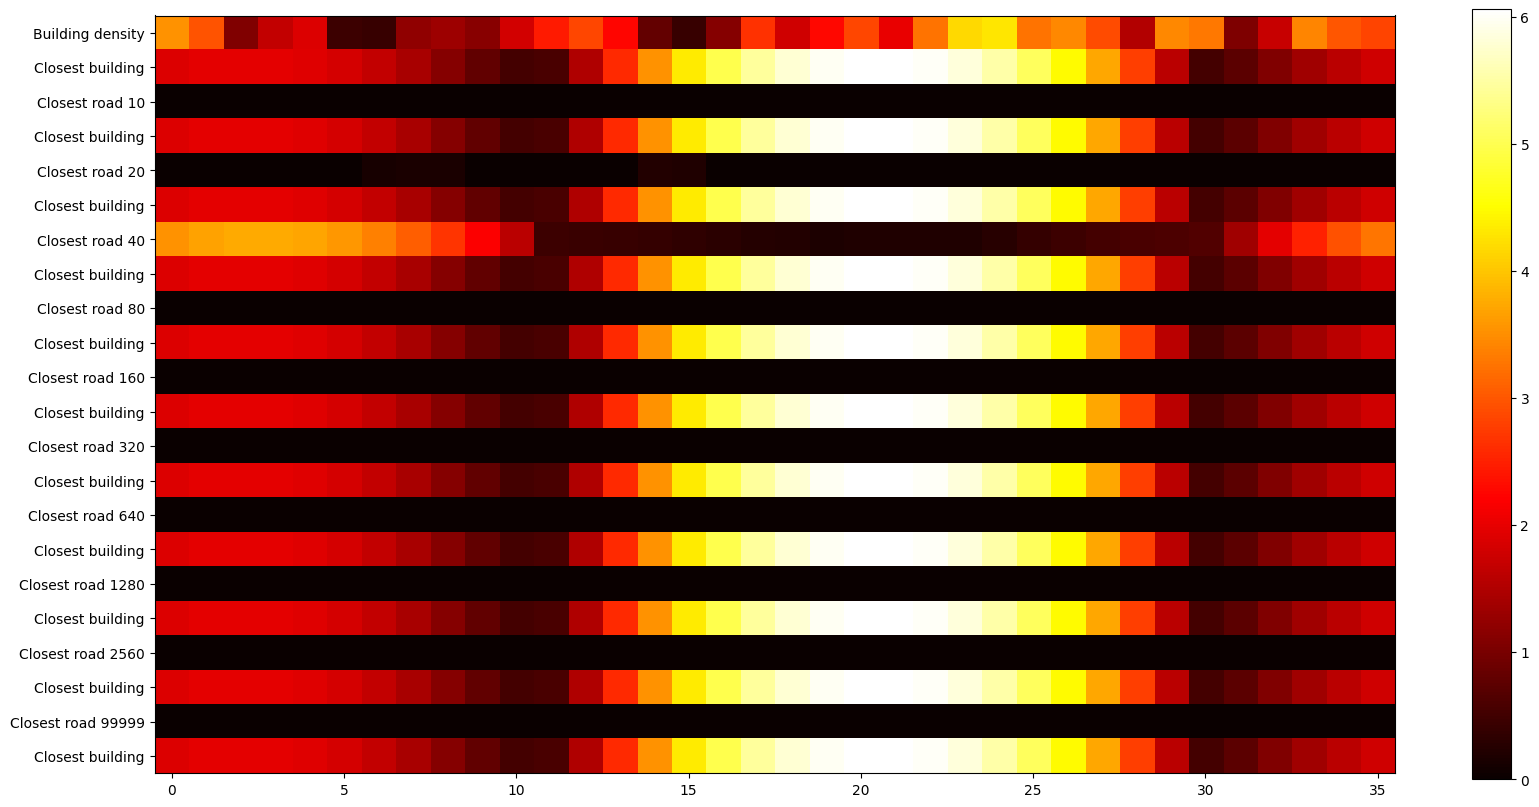

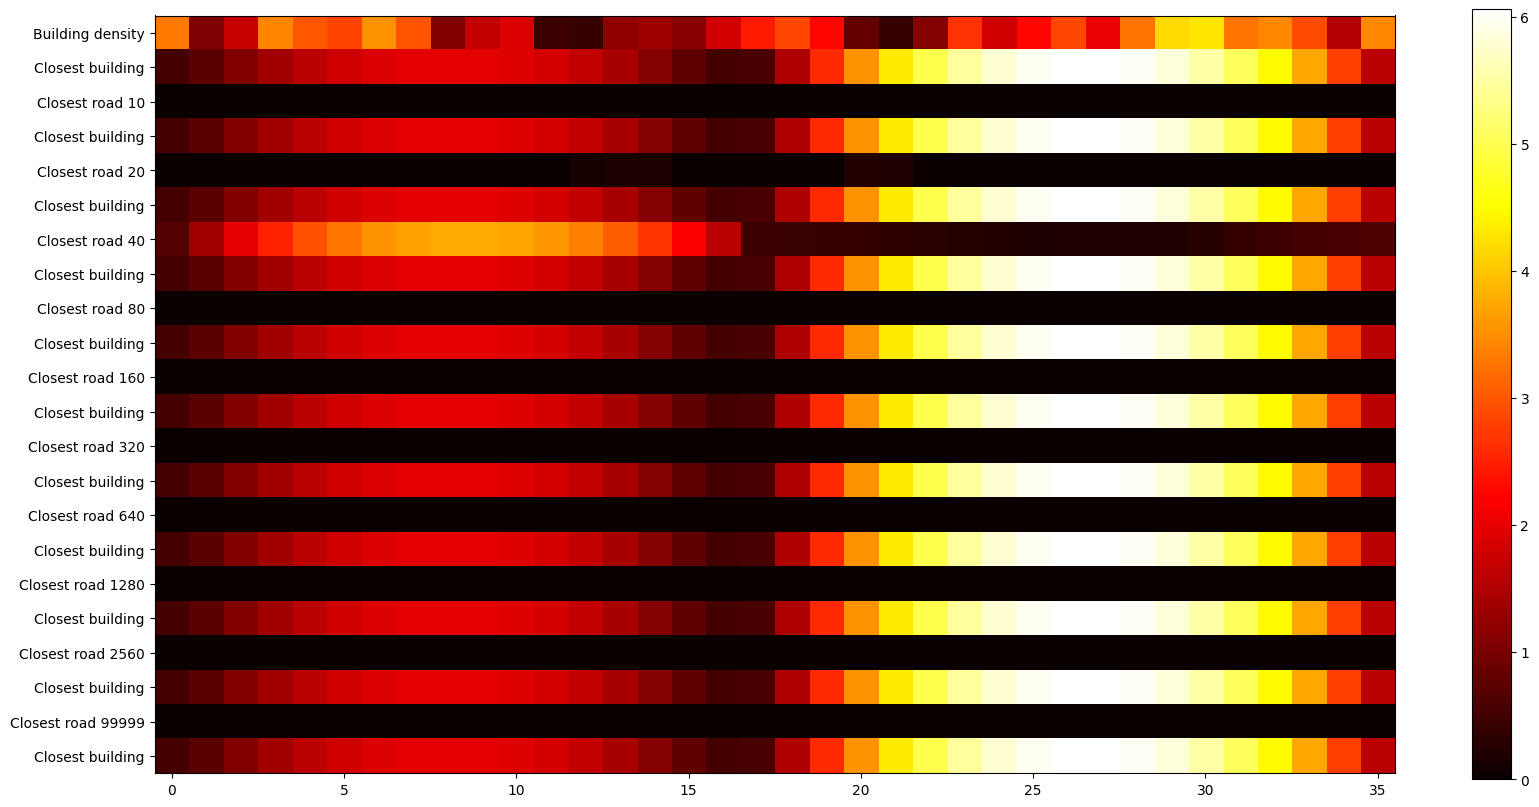

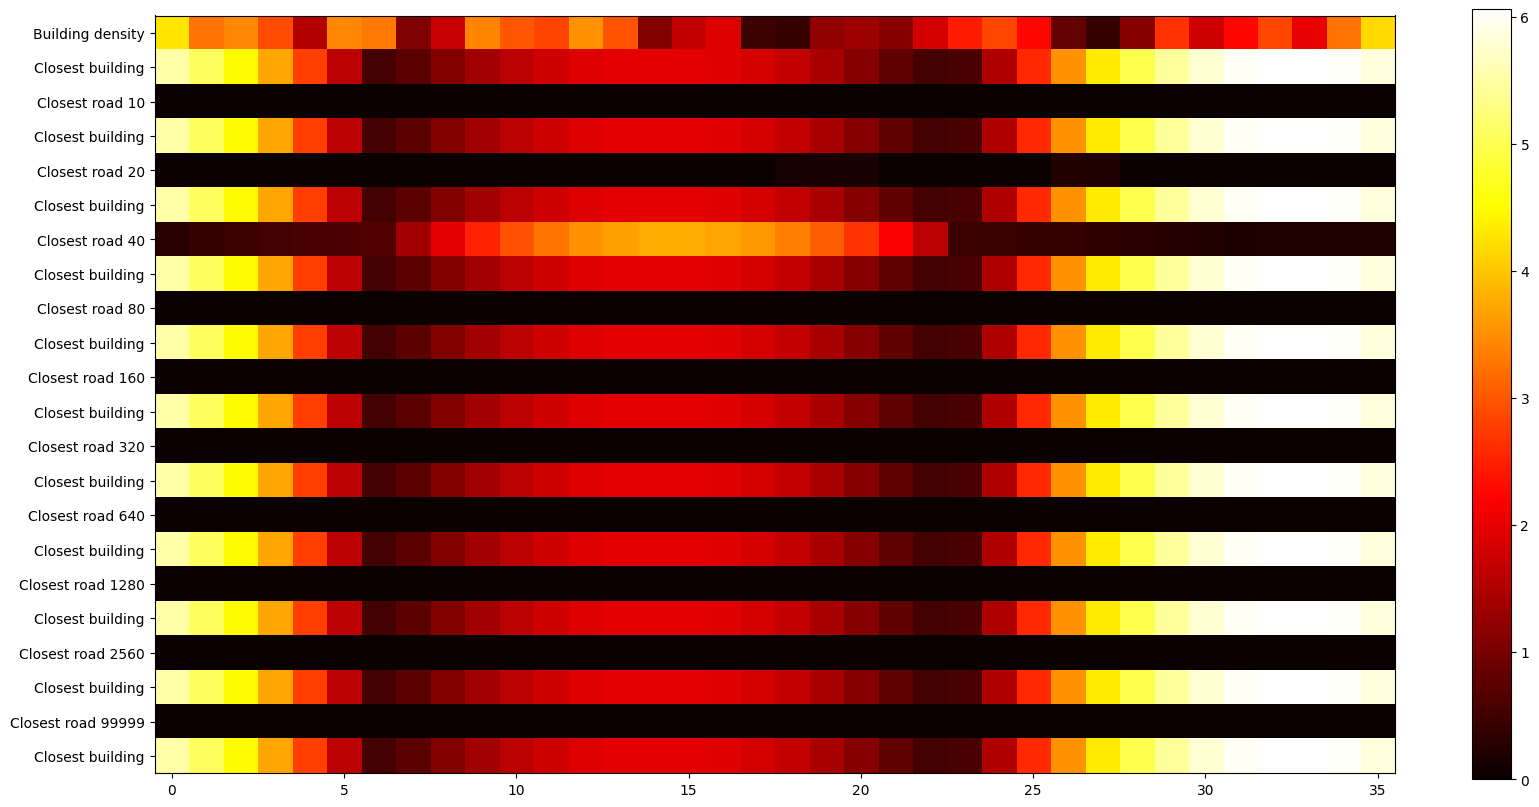

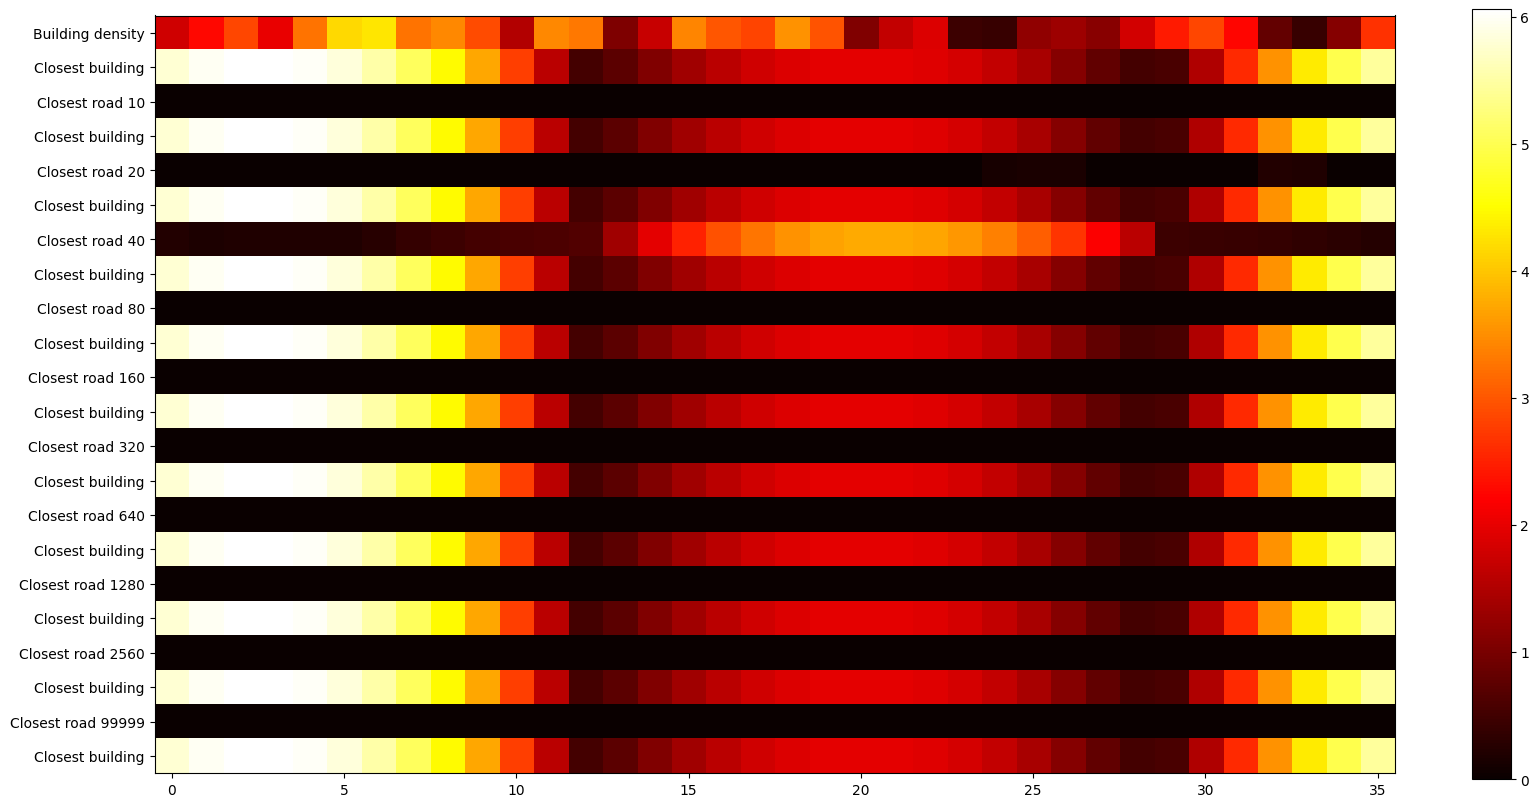

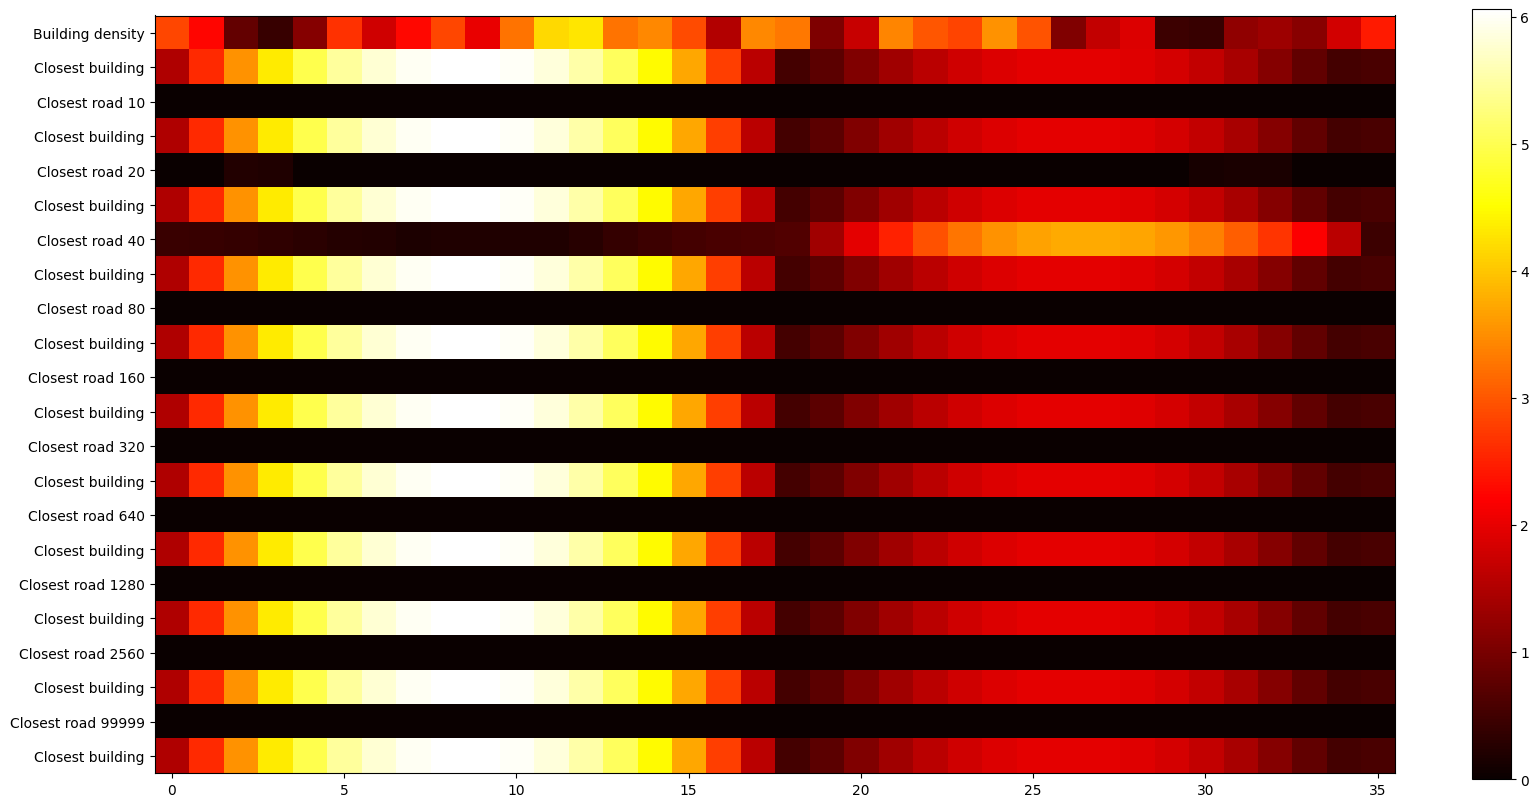

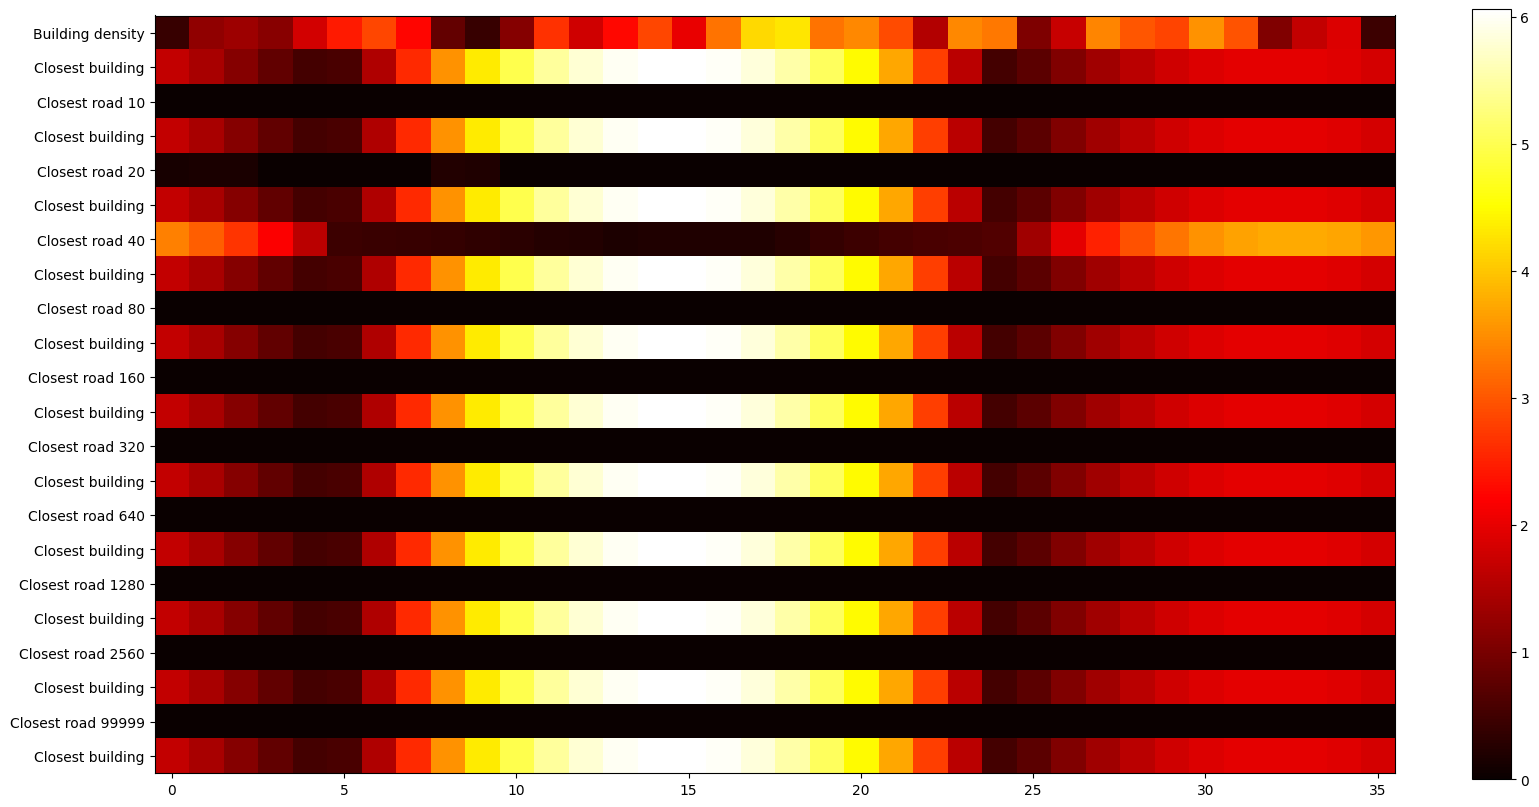

In [10]:
import matplotlib.pyplot as plt
#datapoints = ["Closest building", "Closest road 10", "Closest road 20", "Closest road 40", "Closest road 80", "Closest road 160", "Closest road 320", "Closest road 640", "Closest road 1280", "Closest road 2560", "Closest road 99999"]
datapoints = ["Building density", "Closest building", "Closest road 10", "Closest building", "Closest road 20", "Closest building", "Closest road 40", "Closest building", "Closest road 80", "Closest building", "Closest road 160", "Closest building", "Closest road 320", "Closest building", "Closest road 640", "Closest building", "Closest road 1280", "Closest building", "Closest road 2560", "Closest building", "Closest road 99999", "Closest building"]
fig, ax = plt.subplots(figsize = [20,10])
#print(xo)

im = ax.imshow(imagedata[3])
ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[3], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

fig, ax = plt.subplots(figsize = [20,10])
im = ax.imshow(imagedata[3+shape[0]])
ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[3+shape[0]], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

fig, ax = plt.subplots(figsize = [20,10])
im = ax.imshow(imagedata[3+2*shape[0]])
ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[3+2*shape[0]], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

fig, ax = plt.subplots(figsize = [20,10])
im = ax.imshow(imagedata[3+3*shape[0]])
ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[3+3*shape[0]], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

fig, ax = plt.subplots(figsize = [20,10])
im = ax.imshow(imagedata[3+4*shape[0]])
ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[3+4*shape[0]], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

fig, ax = plt.subplots(figsize = [20,10])
im = ax.imshow(imagedata[3+5*shape[0]])
ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[3+5*shape[0]], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

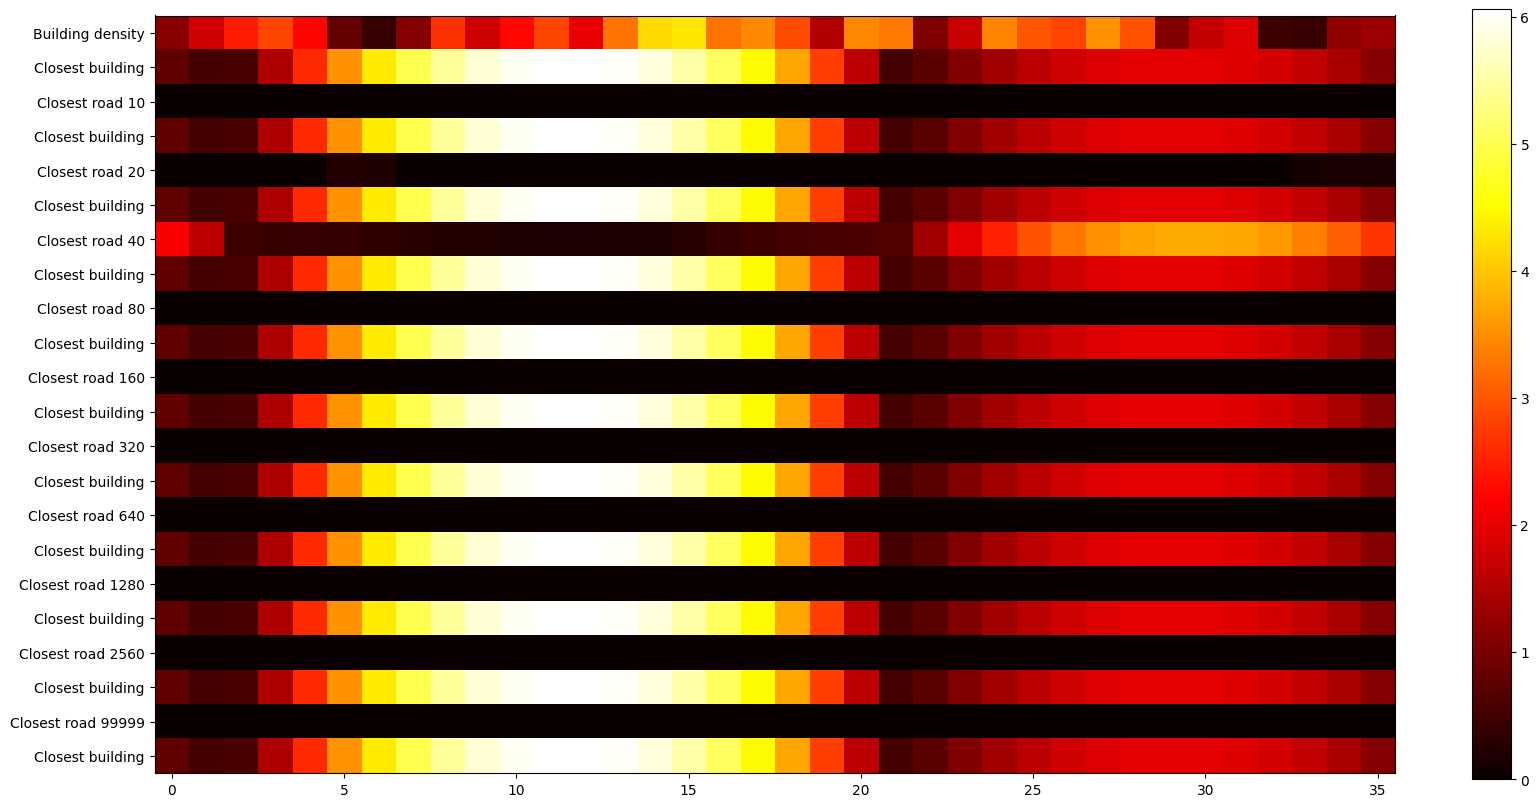

In [11]:
#import random
rolled = np.roll(imagedata[3], random.randint(0,35), axis = 1)

datapoints = ["Building density", "Closest building", "Closest road 10", "Closest building", "Closest road 20", "Closest building", "Closest road 40", "Closest building", "Closest road 80", "Closest building", "Closest road 160", "Closest building", "Closest road 320", "Closest building", "Closest road 640", "Closest building", "Closest road 1280", "Closest building", "Closest road 2560", "Closest building", "Closest road 99999", "Closest building"]
fig, ax = plt.subplots(figsize = [20,10])
im = ax.imshow(rolled)

ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(rolled, cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

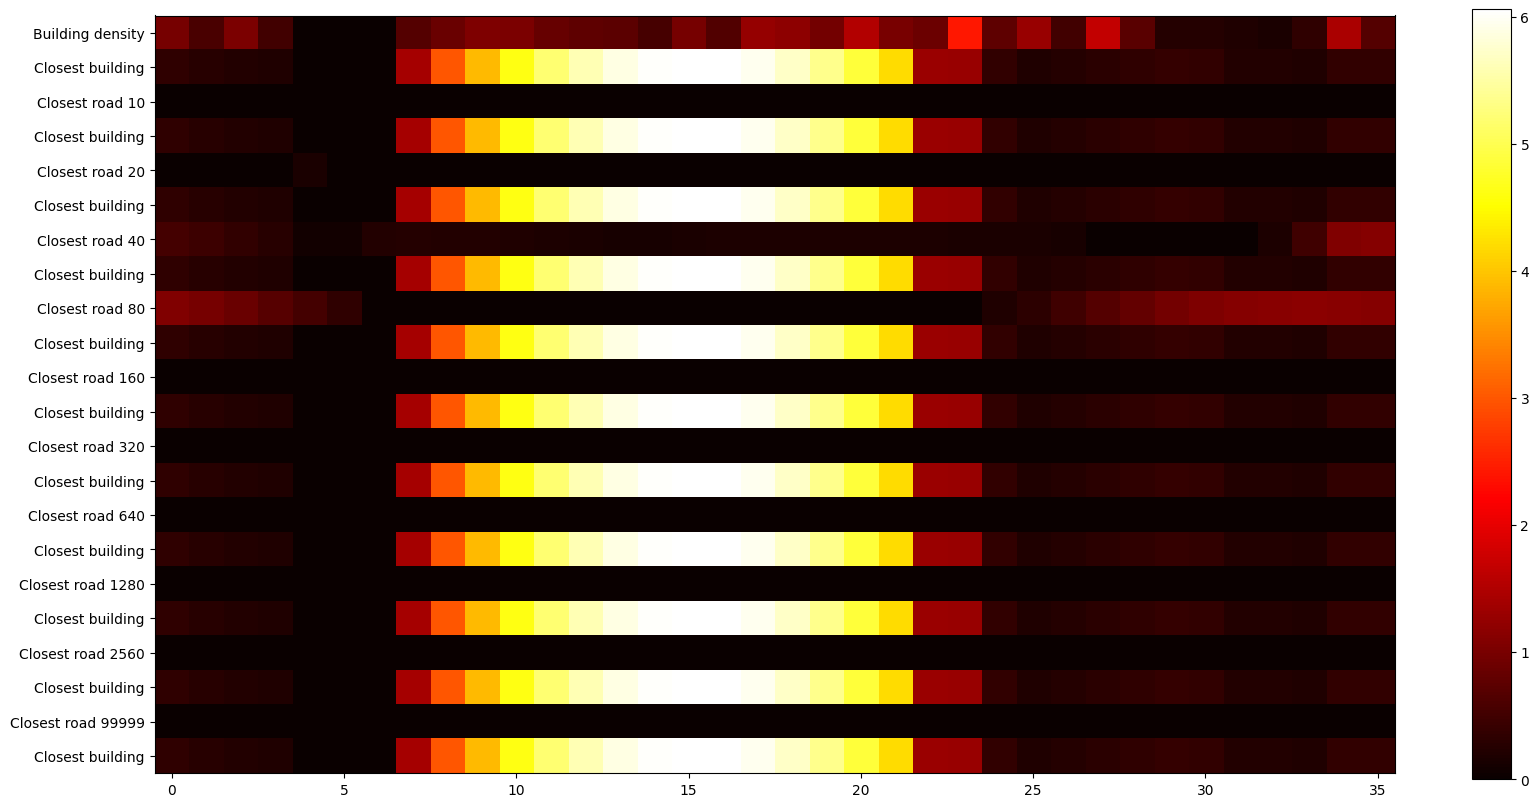

In [12]:
#import matplotlib.pyplot as plt
#datapoints = ["Closest building", "Closest road 10", "Closest road 20", "Closest road 40", "Closest road 80", "Closest road 160", "Closest road 320", "Closest road 640", "Closest road 1280", "Closest road 2560", "Closest road 99999"]
datapoints = ["Building density", "Closest building", "Closest road 10", "Closest building", "Closest road 20", "Closest building", "Closest road 40", "Closest building", "Closest road 80", "Closest building", "Closest road 160", "Closest building", "Closest road 320", "Closest building", "Closest road 640", "Closest building", "Closest road 1280", "Closest building", "Closest road 2560", "Closest building", "Closest road 99999", "Closest building"]
fig, ax = plt.subplots(figsize = [20,10])
#print(xo)
im = ax.imshow(imagedata[326])

ax.set_yticks(np.arange(len(datapoints)), labels=datapoints)
plt.imshow(imagedata[326], cmap='hot', interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.show()

In [17]:
#MODEL WITH CIRCULAR CNN

from tensorflow.keras import layers, Model
from ccnn import CConv2D
#from tensorflow import roll
#from keras.preprocessing.image import ImageDataGenerator
#import random

inputA = layers.Input((22,36,1))     ##
#inp = roll(inp, shift = random.randint(0, 35), axis=1)
#x = layers.ZeroPadding2D(padding=1)(inputA)[:, :, 1:-1] #isn't zero padding handled in CConv2D?
x = CConv2D(10, (3,5), strides=(2,1))(inputA) ##  Convolution part
x = layers.MaxPooling2D((1,3))(x)
#x = layers.ZeroPadding2D(padding=1)(x)[:, :, 1:-1]
x = CConv2D(10, (1,5))(x)
x = layers.MaxPooling2D((1,3))(x)
#x = layers.ZeroPadding2D(padding=1)(x)[:, :, 1:-1]
x = CConv2D(10, (1,5))(x)
x = layers.MaxPooling2D((1,3))(x)
x = layers.Flatten()(x)
x = Model(inputs=inputA, outputs=x)

inputB = layers.Input((20))
y = layers.Flatten()(inputB)
y = Model(inputs=inputB, outputs=y)
#x = layers.Conv2D(1, (1,5))(x)   ##
#x = layers.Conv2D(1, (1,5))(x)   ##
#out = layers.Conv2DTranspose(1, (1,1))(x)   ##
#x = layers.Conv2DTranspose(2, (2,4))(x)   ##  Deconvolution part
#out = layers.Conv2DTranspose(1, (2,4))(x) ##
out = layers.concatenate([x.output, y.output])
out = layers.Dense(400, activation='relu')(out)
out = layers.Dropout((0.6))(out)
#out = layers.BatchNormalization()(out)
out = layers.Dense(200, activation='tanh')(out)
#out = layers.BatchNormalization()(out)
out = layers.Dense(17)(out)
model = Model(inputs=[inputA,inputB], outputs=out)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 22, 36, 1)]  0                                            
__________________________________________________________________________________________________
cropping2d_18 (Cropping2D)      (None, 22, 2, 1)     0           input_8[0][0]                    
__________________________________________________________________________________________________
cropping2d_19 (Cropping2D)      (None, 22, 2, 1)     0           input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 22, 40, 1)    0           cropping2d_18[0][0]              
                                                                 input_8[0][0]        

In [45]:
#TRAIN THE MODEL
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_filepath = './tmpcnn/checkpoint10/'#weights.{epoch:02d}-{val_loss:.2f}/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit([imagedata, distdata], Output, validation_data=([imagedata_val, distdata_val], y_val), epochs=50, callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/50
6443/6443 [==============================] - 115s 18ms/step - loss: 0.1805 - val_loss: 0.1699
Epoch 2/50
6443/6443 [==============================] - 115s 18ms/step - loss: 0.1804 - val_loss: 0.1732
Epoch 3/50
6443/6443 [==============================] - 116s 18ms/step - loss: 0.1804 - val_loss: 0.1683
Epoch 4/50
6443/6443 [==============================] - 115s 18ms/step - loss: 0.1805 - val_loss: 0.1714
Epoch 5/50
6443/6443 [==============================] - 115s 18ms/step - loss: 0.1804 - val_loss: 0.1700
Epoch 6/50
6443/6443 [==============================] - 115s 18ms/step - loss: 0.1803 - val_loss: 0.1700
Epoch 7/50
6443/6443 [==============================] - 117s 18ms/step - loss: 0.1806 - val_loss: 0.1679
Epoch 8/50
6443/6443 [==============================] - 113s 17ms/step - loss: 0.1807 - val_loss: 0.1675
Epoch 9/50
6443/6443 [==============================] - 115s 18ms/step - loss: 0.1806 - val_loss: 0.1732
Epoch 10/50
6443/6443 [==============================] 

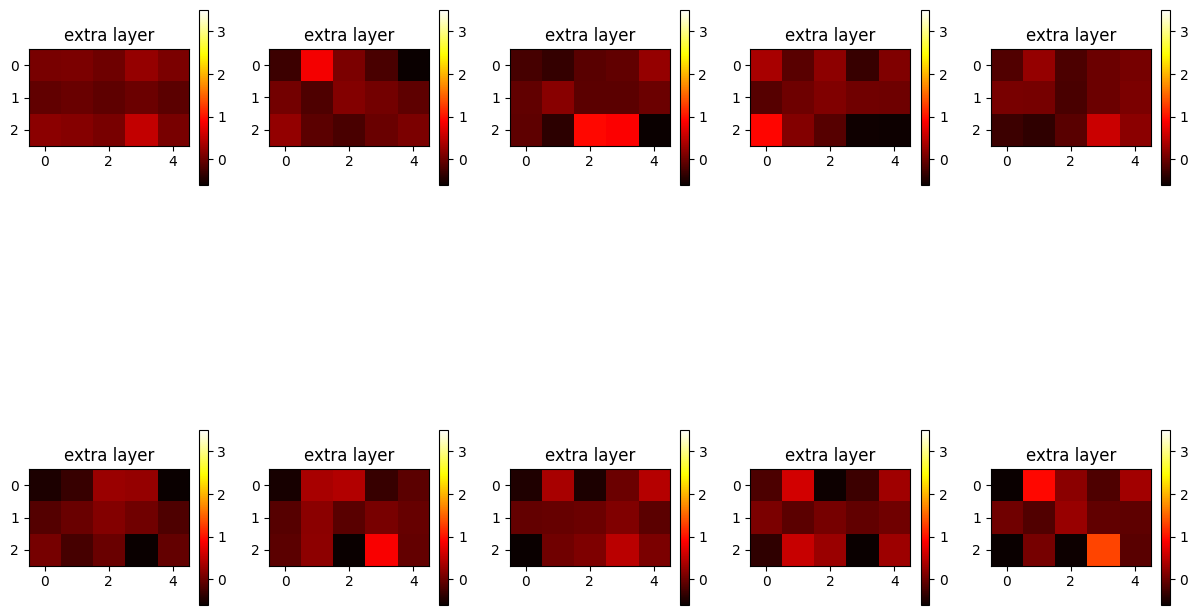

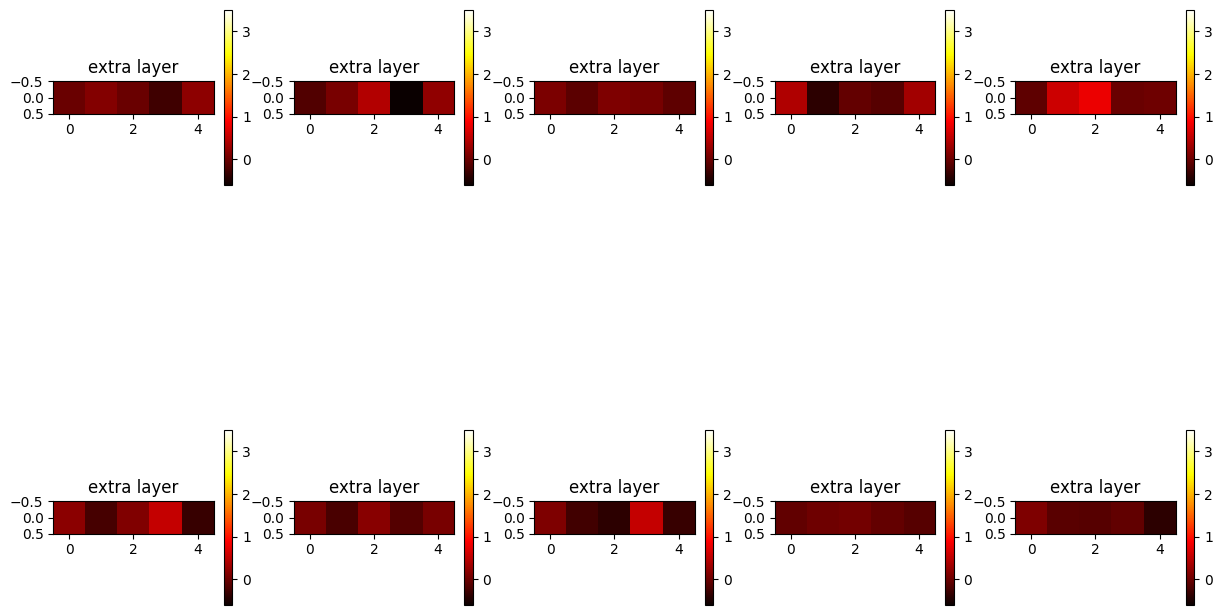

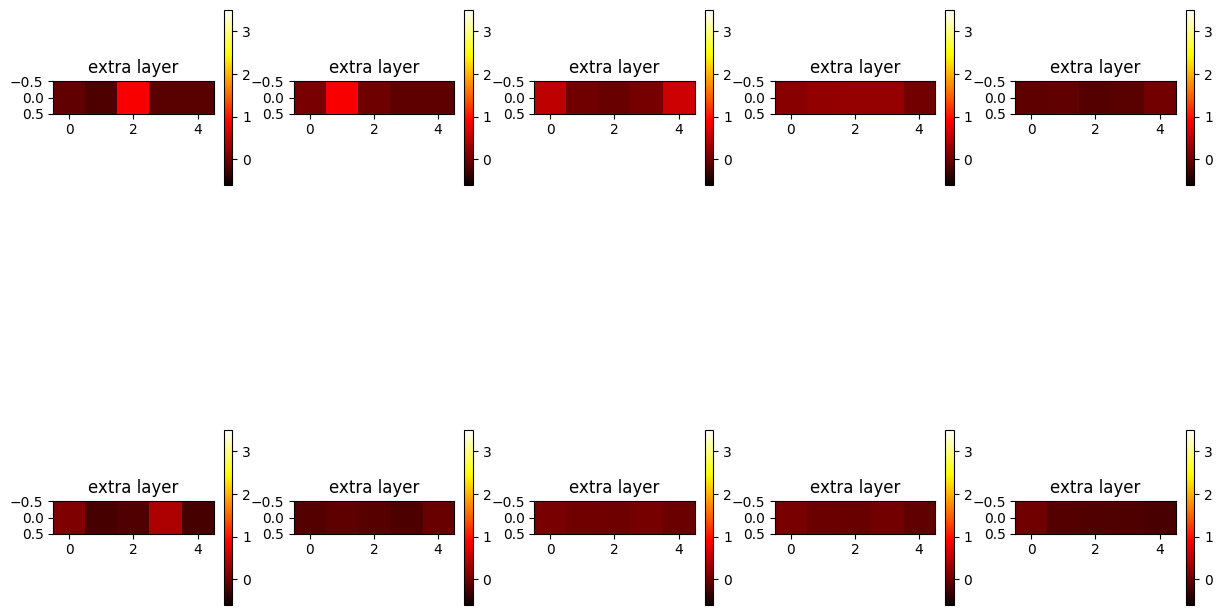

In [46]:
#VISUALISE FILTERS
import matplotlib.pyplot as plt
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))
    for i in range(10):
        if layer.name == 'conv2d':
            layer_name = "Conv Layer 1"
        elif layer.name == 'conv2d_1':
            layer_name = "Conv Layer 2"
        elif layer.name == 'conv2d_2':
            layer_name = "Conv Layer 3"
        else:
            layer_name = 'extra layer'
        im = axs[int(i>4), i%5].imshow(filters[:, :, 0, i], cmap='hot', vmin=-0.6, vmax=3.5)
        axs[int(i>4), i%5].set_title(layer_name)
        fig.colorbar(im, ax=axs[int(i>4), i%5], shrink=0.5)

dict_keys(['loss', 'val_loss'])


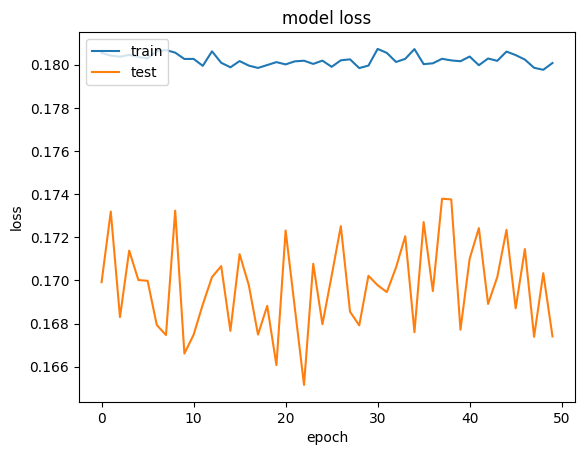

In [47]:
#import numpy as np
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


(206148, 17)
[[4.6365856e+01 4.0670982e+01 4.1400169e+01 ... 6.5912753e-02
  2.3466054e-01 2.3466043e-01]
 [4.7319530e+01 2.4607203e+01 2.2969833e+01 ... 1.6562578e-01
  2.6103270e-01 2.6103273e-01]
 [3.3937199e+01 2.8062567e+01 2.8236912e+01 ... 5.9741400e-03
  7.6910430e-03 7.6911622e-03]
 ...
 [4.3570374e+01 3.3096466e+01 2.5739639e+01 ... 5.8816131e-02
  1.5774907e-01 1.5774901e-01]
 [4.9793411e+01 2.9817829e+01 2.5436018e+01 ... 2.6118824e-01
  3.9623666e-01 3.9623675e-01]
 [4.9376877e+01 1.8945921e+01 1.8079723e+01 ... 1.9493382e-01
  2.7888063e-01 2.7888072e-01]]
[4.7319530e+01 2.4607203e+01 2.2969833e+01 1.4484015e+01 9.2413467e+01
 2.0286107e+02 1.1026999e+02 1.0190683e+03 6.3140669e+00 7.0014411e-01
 2.8943032e-01 1.2998539e+00 1.0978004e+00 8.0898426e-02 1.6562578e-01
 2.6103270e-01 2.6103273e-01]
0.04780801
[ 3.3937199e+01  2.8062567e+01  2.8236912e+01  4.1891580e+00
  8.1721573e+01  1.4288600e+02  2.7052040e+01  5.5932520e+02
  1.6500067e+00  7.7505571e-01  8.2484442e-01  

Text(0.5, 1.0, 'PSD_12_18')

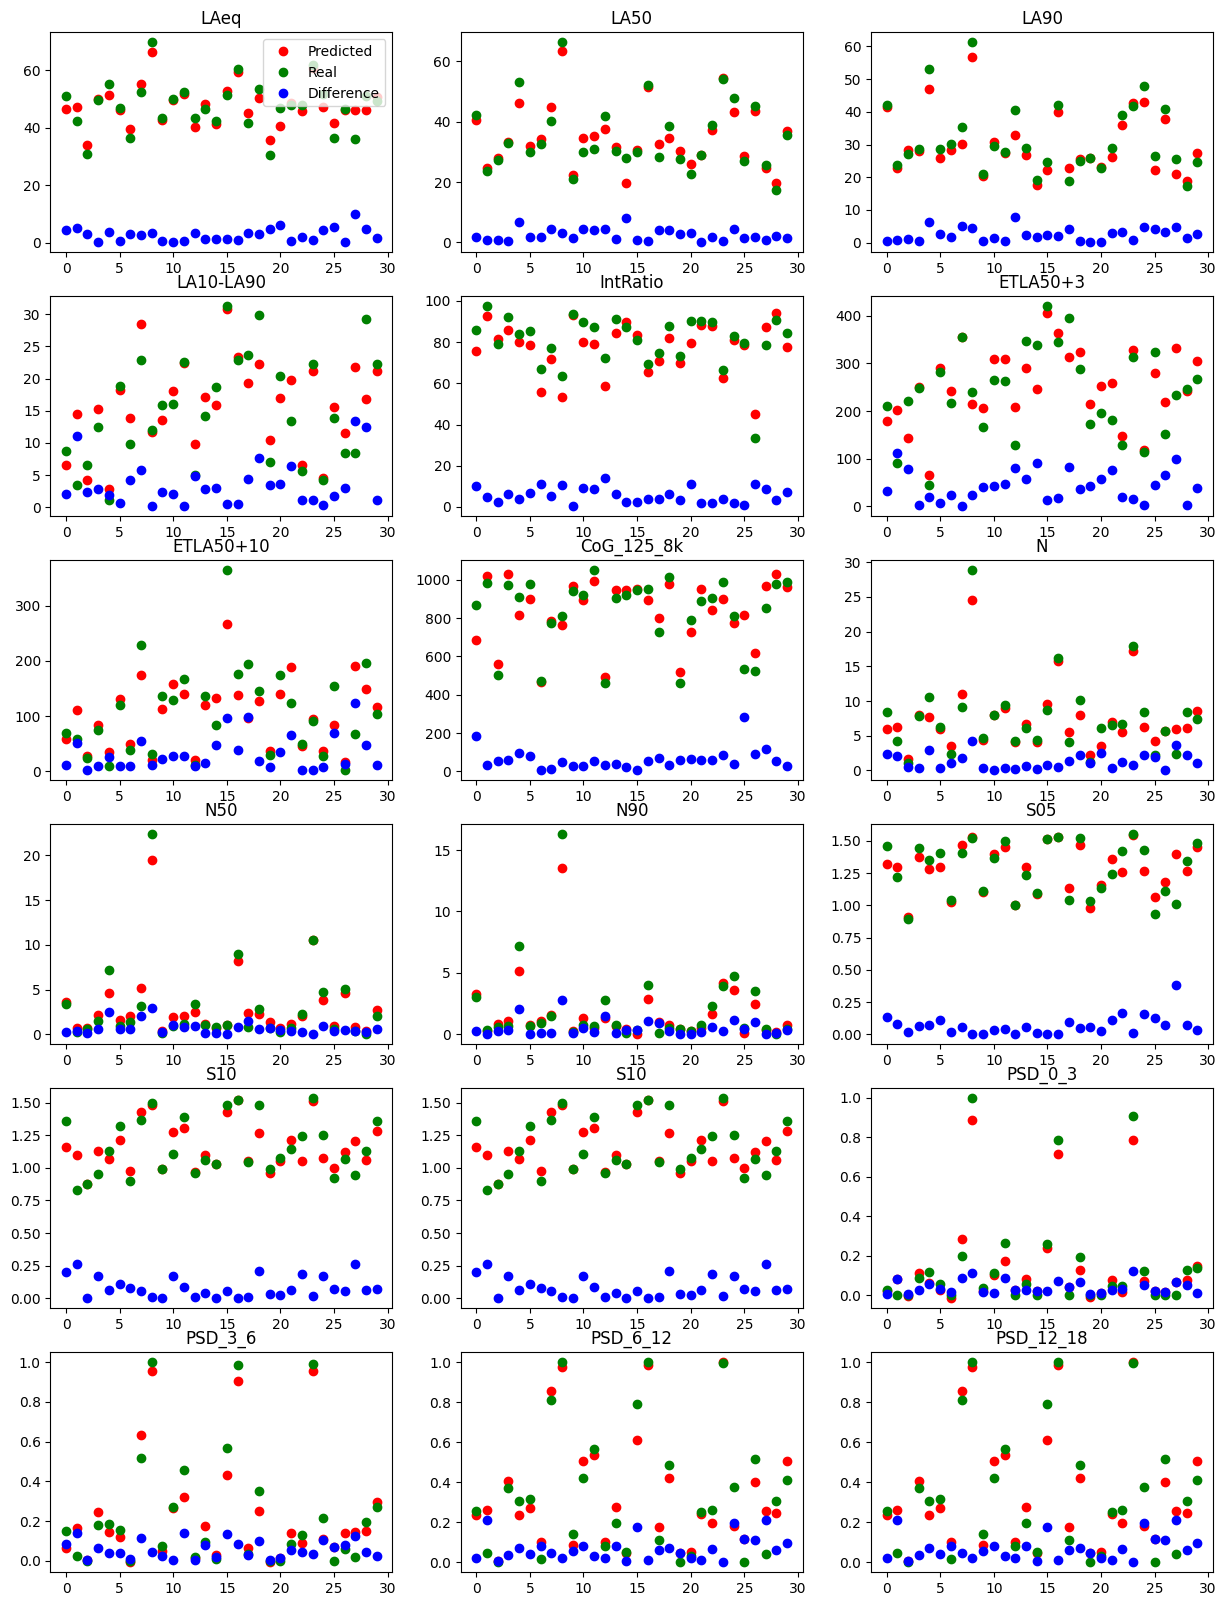

In [48]:
#PREDICTION OWN DATA
#import numpy as np
#import matplotlib.pyplot as plt
#import keras
#import pickle

#testmodel.load_weights('./tmp2/checkpoint/weights.268-861.88/')
#testmodel2 = keras.models.load_model('model1307')
ml_cols = ["LAeq", "LA50", "LA90", "LA10-LA90", "IntRatio", "ETLA50+3", "ETLA50+10", "CoG_125_8k", "N", "N50", "N90", "S05", "S10", "PSD_0_3", "PSD_3_6", "PSD_6_12", "PSD_12_18"]
    
z = model.predict([imagedata,distdata])
#z = model.predict(input_data_scaled)
output_features_def = scaler_output.inverse_transform(Output)
y = scaler_output.inverse_transform(z)
out_arr = np.subtract(y, output_features_def)
print(y.shape)
print(y)
print(y[1])
print(output_features_def[1,16])
print(y[2])
print(output_features_def[2,16])
print(y[511])
print(output_features_def[511,16])
print(y[736])
print(output_features_def[736,16])
x = np.array(range(0, 30))


fig, axs = plt.subplots(6, 3, figsize=(15, 20))
axs[0, 0].plot(x, y[:30,0], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[0, 0].plot(x, output_features_def[:30,0], color = "green", marker = "o", label = "Real",linestyle="None")
axs[0, 0].plot(x, abs(out_arr[:30,0]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[0, 0].legend()
axs[0, 0].set_title(ml_cols[0])
axs[0, 1].plot(x, y[:30,1], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[0, 1].plot(x, output_features_def[:30,1], color = "green", marker = "o", label = "Real",linestyle="None")
axs[0, 1].plot(x, abs(out_arr[:30,1]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[0, 1].set_title(ml_cols[1])
axs[0, 2].plot(x, y[:30,2], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[0, 2].plot(x, output_features_def[:30,2], color = "green", marker = "o", label = "Real",linestyle="None")
axs[0, 2].plot(x, abs(out_arr[:30,2]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[0, 2].set_title(ml_cols[2])
axs[1, 0].plot(x, y[:30,3], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[1, 0].plot(x, output_features_def[:30,3], color = "green", marker = "o", label = "Real",linestyle="None")
axs[1, 0].plot(x, abs(out_arr[:30,3]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[1, 0].set_title(ml_cols[3])
axs[1, 1].plot(x, y[:30,4], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[1, 1].plot(x, output_features_def[:30,4], color = "green", marker = "o", label = "Real",linestyle="None")
axs[1, 1].plot(x, abs(out_arr[:30,4]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[1, 1].set_title(ml_cols[4])
axs[1, 2].plot(x, y[:30,5], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[1, 2].plot(x, output_features_def[:30,5], color = "green", marker = "o", label = "Real",linestyle="None")
axs[1, 2].plot(x, abs(out_arr[:30,5]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[1, 2].set_title(ml_cols[5])
axs[2, 0].plot(x, y[:30,6], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[2, 0].plot(x, output_features_def[:30,6], color = "green", marker = "o", label = "Real",linestyle="None")
axs[2, 0].plot(x, abs(out_arr[:30,6]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[2, 0].set_title(ml_cols[6])
axs[2, 1].plot(x, y[:30,7], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[2, 1].plot(x, output_features_def[:30,7], color = "green", marker = "o", label = "Real",linestyle="None")
axs[2, 1].plot(x, abs(out_arr[:30,7]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[2, 1].set_title(ml_cols[7])
axs[2, 2].plot(x, y[:30,8], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[2, 2].plot(x, output_features_def[:30,8], color = "green", marker = "o", label = "Real",linestyle="None")
axs[2, 2].plot(x, abs(out_arr[:30,8]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[2, 2].set_title(ml_cols[8])
axs[3, 0].plot(x, y[:30,9], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[3, 0].plot(x, output_features_def[:30,9], color = "green", marker = "o", label = "Real",linestyle="None")
axs[3, 0].plot(x, abs(out_arr[:30,9]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[3, 0].set_title(ml_cols[9])
axs[3, 1].plot(x, y[:30,10], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[3, 1].plot(x, output_features_def[:30,10], color = "green", marker = "o", label = "Real",linestyle="None")
axs[3, 1].plot(x, abs(out_arr[:30,10]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[3, 1].set_title(ml_cols[10])
axs[3, 2].plot(x, y[:30,11], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[3, 2].plot(x, output_features_def[:30,11], color = "green", marker = "o", label = "Real",linestyle="None")
axs[3, 2].plot(x, abs(out_arr[:30,11]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[3, 2].set_title(ml_cols[11])
axs[4, 0].plot(x, y[:30,12], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[4, 0].plot(x, output_features_def[:30,12], color = "green", marker = "o", label = "Real",linestyle="None")
axs[4, 0].plot(x, abs(out_arr[:30,12]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[4, 0].set_title(ml_cols[12])
axs[4, 1].plot(x, y[:30,12], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[4, 1].plot(x, output_features_def[:30,12], color = "green", marker = "o", label = "Real",linestyle="None")
axs[4, 1].plot(x, abs(out_arr[:30,12]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[4, 1].set_title(ml_cols[12])
axs[4, 2].plot(x, y[:30,13], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[4, 2].plot(x, output_features_def[:30,13], color = "green", marker = "o", label = "Real",linestyle="None")
axs[4, 2].plot(x, abs(out_arr[:30,13]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[4, 2].set_title(ml_cols[13])
axs[5, 0].plot(x, y[:30,14], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[5, 0].plot(x, output_features_def[:30,14], color = "green", marker = "o", label = "Real",linestyle="None")
axs[5, 0].plot(x, abs(out_arr[:30,14]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[5, 0].set_title(ml_cols[14])
axs[5, 1].plot(x, y[:30,15], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[5, 1].plot(x, output_features_def[:30,15], color = "green", marker = "o", label = "Real",linestyle="None")
axs[5, 1].plot(x, abs(out_arr[:30,15]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[5, 1].set_title(ml_cols[15])
axs[5, 2].plot(x, y[:30,16], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[5, 2].plot(x, output_features_def[:30,16], color = "green", marker = "o", label = "Real",linestyle="None")
axs[5, 2].plot(x, abs(out_arr[:30,16]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[5, 2].set_title(ml_cols[16])


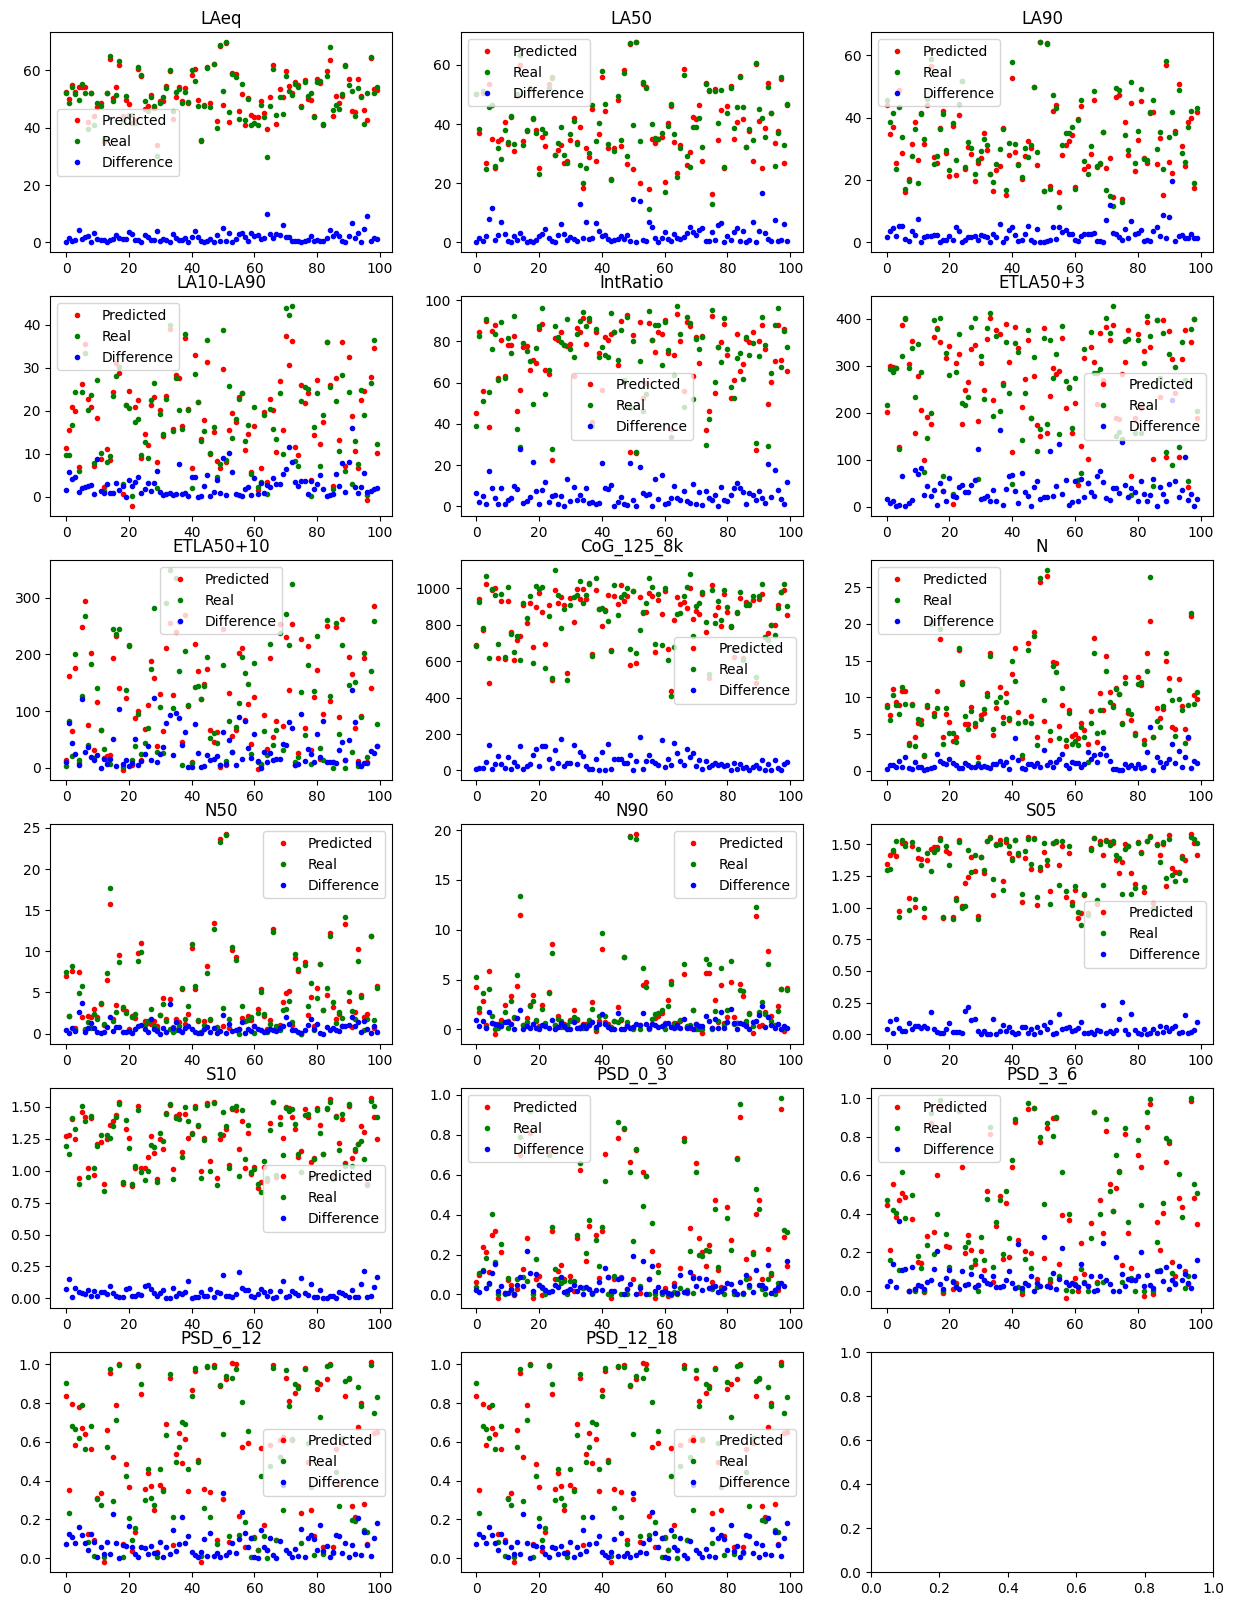

In [49]:
select = range(1000,1100)
x = np.array(range(len(y[select,:])))
fig, axs = plt.subplots(6, 3, figsize=(15, 20))
for c in range(6):
    for d in range(3):
        if c == 5 and d == 2:
            continue
        axs[c, d].plot(x, y[select,(c*3)+d], color = "red", marker = ".", label = "Predicted",linestyle="None")
        axs[c, d].plot(x, output_features_def[select,(c*3)+d], color = "green", marker = ".", label = "Real",linestyle="None")
        axs[c, d].plot(x, abs(out_arr[select,(c*3)+d]), color = "blue", marker = ".", label = "Difference",linestyle="None")
        axs[c, d].legend()
        axs[c, d].set_title(ml_cols[(c*3)+d])

(6216, 17)
[[51.674385   28.934341   24.137373   ...  0.3156226   0.44875878
   0.448759  ]
 [51.674385   28.934341   24.137373   ...  0.3156226   0.44875878
   0.448759  ]
 [51.674385   28.934341   24.137373   ...  0.3156226   0.44875878
   0.448759  ]
 ...
 [59.06144    50.783836   43.894947   ...  0.7715505   0.8745012
   0.8745012 ]
 [59.061436   50.783836   43.894947   ...  0.7715506   0.8745012
   0.8745012 ]
 [59.061436   50.783836   43.894947   ...  0.7715506   0.8745012
   0.8745012 ]]
[5.16743851e+01 2.89343414e+01 2.41373730e+01 1.87564774e+01
 8.83850632e+01 2.92529114e+02 1.29839905e+02 1.04045886e+03
 9.03281879e+00 8.23193848e-01 1.14187665e-01 1.38563561e+00
 1.20025730e+00 1.81412503e-01 3.15622598e-01 4.48758781e-01
 4.48758990e-01]
0.33422616
[5.16743851e+01 2.89343414e+01 2.41373730e+01 1.87564774e+01
 8.83850632e+01 2.92529114e+02 1.29839905e+02 1.04045886e+03
 9.03281879e+00 8.23193848e-01 1.14187665e-01 1.38563561e+00
 1.20025730e+00 1.81412503e-01 3.15622598e-01

Text(0.5, 1.0, 'PSD_12_18')

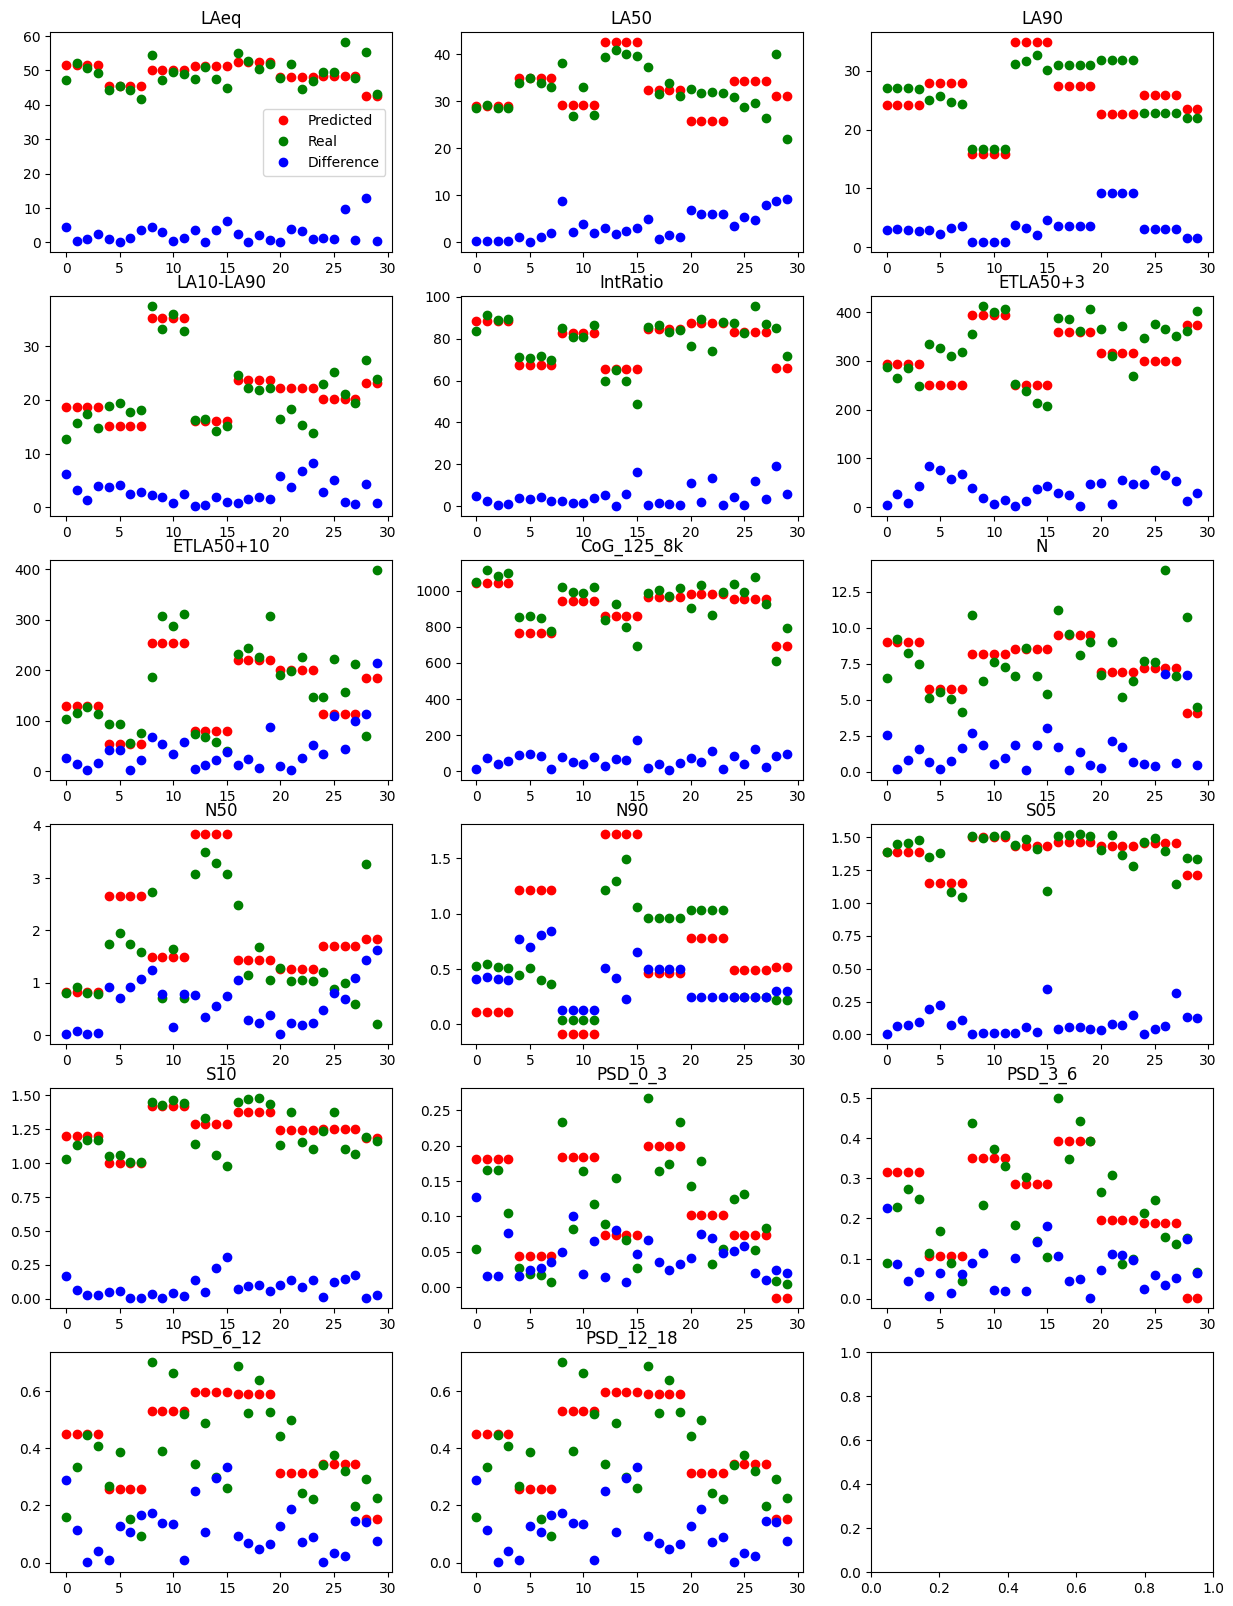

In [50]:
#PREDICTION NEW DATA
#import numpy as np
#import matplotlib.pyplot as plt
#import keras
#import pickle

#testmodel.load_weights('./tmp2/checkpoint/weights.268-861.88/')
#testmodel2 = keras.models.load_model('model1307')
ml_cols = ["LAeq", "LA50", "LA90", "LA10-LA90", "IntRatio", "ETLA50+3", "ETLA50+10", "CoG_125_8k", "N", "N50", "N90", "S05", "S10", "PSD_0_3", "PSD_3_6", "PSD_6_12", "PSD_12_18"]
    
z = model.predict([imagedata_test, distdata_test])
#z = model.predict(input_data_scaled)
output_features_def = scaler_output.inverse_transform(output_features_test_scaled)
y = scaler_output.inverse_transform(z)
out_arr = np.subtract(y, output_features_test)
print(y.shape)
print(y)
print(y[1])
print(output_features_def[1,16])
print(y[2])
print(output_features_def[2,16])
print(y[511])
print(output_features_def[511,16])
print(y[736])
print(output_features_def[736,16])
x = np.array(range(0, 30))


fig, axs = plt.subplots(6, 3, figsize=(15, 20))
axs[0, 0].plot(x, y[:30,0], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[0, 0].plot(x, output_features_test[:30,0], color = "green", marker = "o", label = "Real",linestyle="None")
axs[0, 0].plot(x, abs(out_arr[:30,0]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[0, 0].legend()
axs[0, 0].set_title(ml_cols[0])
axs[0, 1].plot(x, y[:30,1], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[0, 1].plot(x, output_features_test[:30,1], color = "green", marker = "o", label = "Real",linestyle="None")
axs[0, 1].plot(x, abs(out_arr[:30,1]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[0, 1].set_title(ml_cols[1])
axs[0, 2].plot(x, y[:30,2], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[0, 2].plot(x, output_features_test[:30,2], color = "green", marker = "o", label = "Real",linestyle="None")
axs[0, 2].plot(x, abs(out_arr[:30,2]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[0, 2].set_title(ml_cols[2])
axs[1, 0].plot(x, y[:30,3], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[1, 0].plot(x, output_features_test[:30,3], color = "green", marker = "o", label = "Real",linestyle="None")
axs[1, 0].plot(x, abs(out_arr[:30,3]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[1, 0].set_title(ml_cols[3])
axs[1, 1].plot(x, y[:30,4], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[1, 1].plot(x, output_features_test[:30,4], color = "green", marker = "o", label = "Real",linestyle="None")
axs[1, 1].plot(x, abs(out_arr[:30,4]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[1, 1].set_title(ml_cols[4])
axs[1, 2].plot(x, y[:30,5], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[1, 2].plot(x, output_features_test[:30,5], color = "green", marker = "o", label = "Real",linestyle="None")
axs[1, 2].plot(x, abs(out_arr[:30,5]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[1, 2].set_title(ml_cols[5])
axs[2, 0].plot(x, y[:30,6], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[2, 0].plot(x, output_features_test[:30,6], color = "green", marker = "o", label = "Real",linestyle="None")
axs[2, 0].plot(x, abs(out_arr[:30,6]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[2, 0].set_title(ml_cols[6])
axs[2, 1].plot(x, y[:30,7], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[2, 1].plot(x, output_features_test[:30,7], color = "green", marker = "o", label = "Real",linestyle="None")
axs[2, 1].plot(x, abs(out_arr[:30,7]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[2, 1].set_title(ml_cols[7])
axs[2, 2].plot(x, y[:30,8], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[2, 2].plot(x, output_features_test[:30,8], color = "green", marker = "o", label = "Real",linestyle="None")
axs[2, 2].plot(x, abs(out_arr[:30,8]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[2, 2].set_title(ml_cols[8])
axs[3, 0].plot(x, y[:30,9], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[3, 0].plot(x, output_features_test[:30,9], color = "green", marker = "o", label = "Real",linestyle="None")
axs[3, 0].plot(x, abs(out_arr[:30,9]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[3, 0].set_title(ml_cols[9])
axs[3, 1].plot(x, y[:30,10], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[3, 1].plot(x, output_features_test[:30,10], color = "green", marker = "o", label = "Real",linestyle="None")
axs[3, 1].plot(x, abs(out_arr[:30,10]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[3, 1].set_title(ml_cols[10])
axs[3, 2].plot(x, y[:30,11], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[3, 2].plot(x, output_features_test[:30,11], color = "green", marker = "o", label = "Real",linestyle="None")
axs[3, 2].plot(x, abs(out_arr[:30,11]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[3, 2].set_title(ml_cols[11])
axs[4, 0].plot(x, y[:30,12], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[4, 0].plot(x, output_features_test[:30,12], color = "green", marker = "o", label = "Real",linestyle="None")
axs[4, 0].plot(x, abs(out_arr[:30,12]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[4, 0].set_title(ml_cols[12])
axs[4, 1].plot(x, y[:30,13], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[4, 1].plot(x, output_features_test[:30,13], color = "green", marker = "o", label = "Real",linestyle="None")
axs[4, 1].plot(x, abs(out_arr[:30,13]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[4, 1].set_title(ml_cols[13])
axs[4, 2].plot(x, y[:30,14], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[4, 2].plot(x, output_features_def[:30,14], color = "green", marker = "o", label = "Real",linestyle="None")
axs[4, 2].plot(x, abs(out_arr[:30,14]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[4, 2].set_title(ml_cols[14])
axs[5, 0].plot(x, y[:30,15], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[5, 0].plot(x, output_features_test[:30,15], color = "green", marker = "o", label = "Real",linestyle="None")
axs[5, 0].plot(x, abs(out_arr[:30,15]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[5, 0].set_title(ml_cols[15])
axs[5, 1].plot(x, y[:30,16], color = "red", marker = "o", label = "Predicted",linestyle="None")
axs[5, 1].plot(x, output_features_test[:30,16], color = "green", marker = "o", label = "Real",linestyle="None")
axs[5, 1].plot(x, abs(out_arr[:30,16]), color = "blue", marker = "o", label = "Difference",linestyle="None")
axs[5, 1].set_title(ml_cols[16])


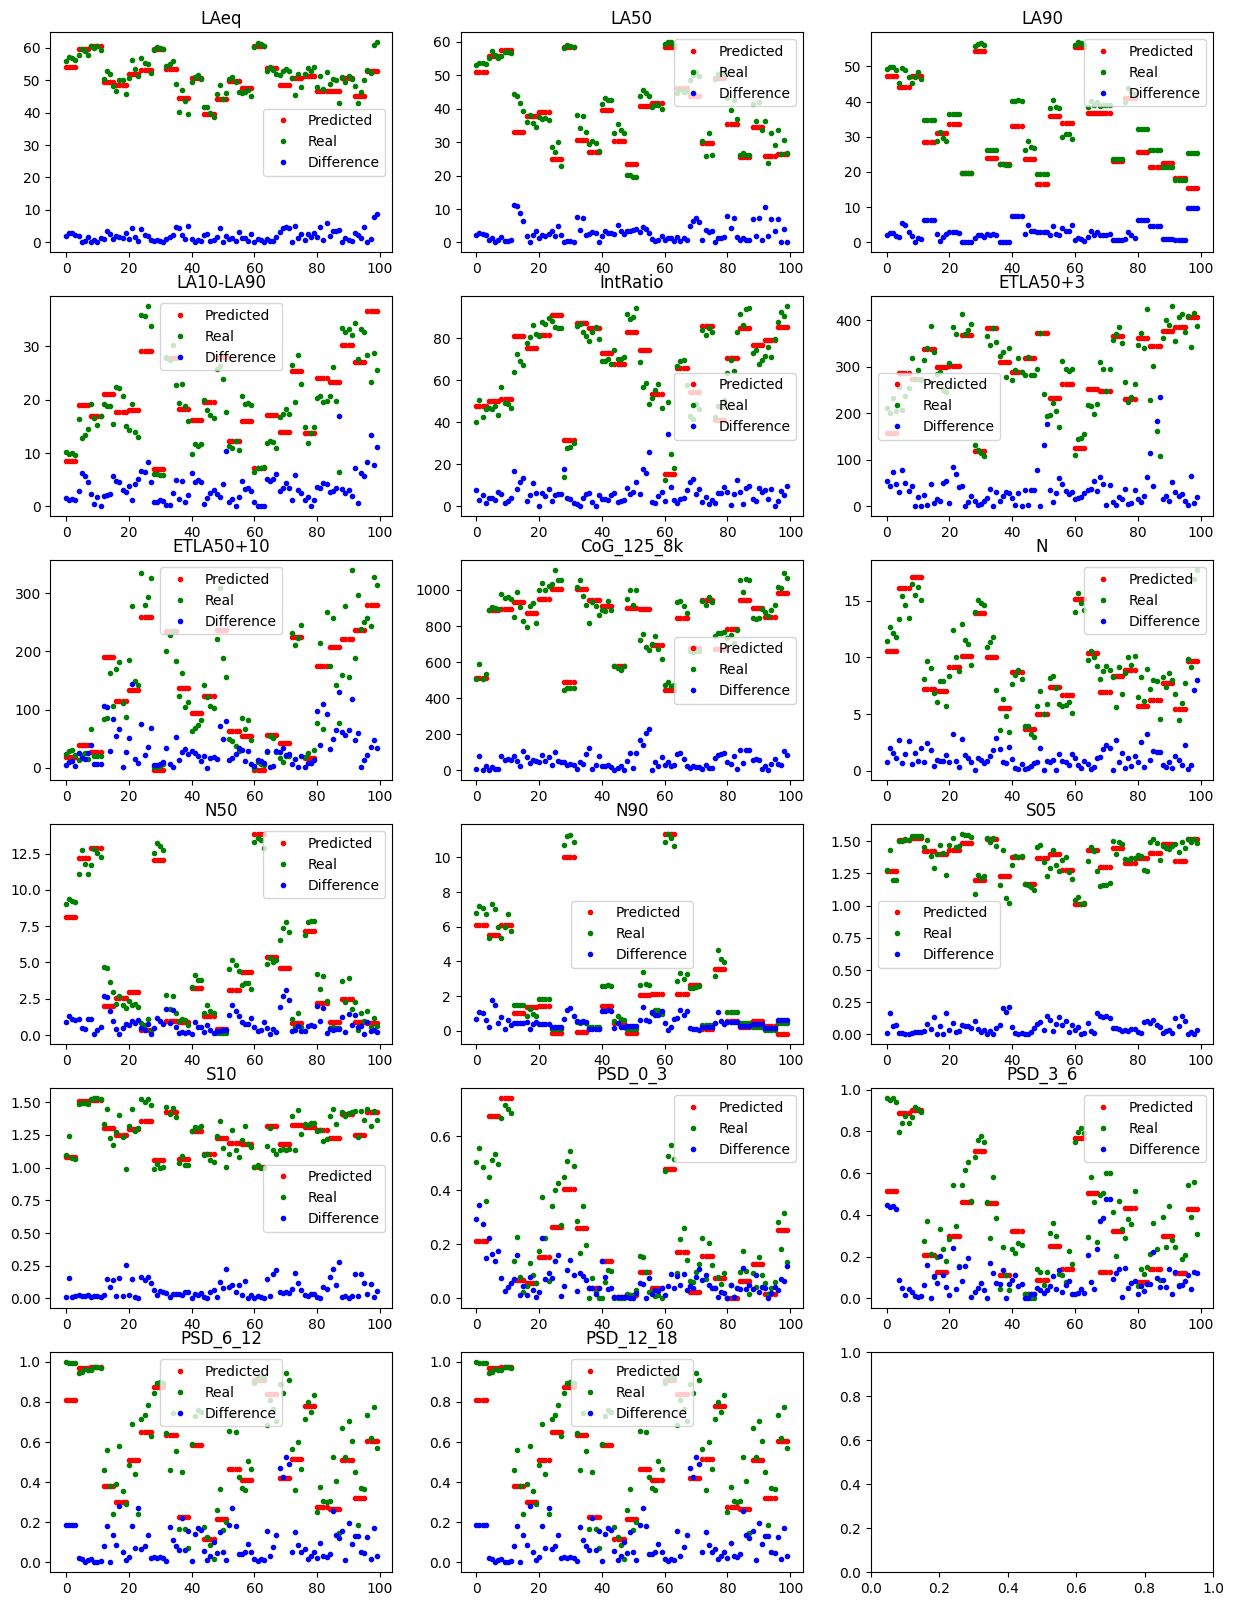

In [51]:
select = range(1000,1100)
x = np.array(range(len(y[select,:])))
fig, axs = plt.subplots(6, 3, figsize=(15, 20))
for c in range(6):
    for d in range(3):
        if c == 5 and d == 2:
            continue
        axs[c, d].plot(x, y[select,(c*3)+d], color = "red", marker = ".", label = "Predicted",linestyle="None")
        axs[c, d].plot(x, output_features_def[select,(c*3)+d], color = "green", marker = ".", label = "Real",linestyle="None")
        axs[c, d].plot(x, abs(out_arr[select,(c*3)+d]), color = "blue", marker = ".", label = "Difference",linestyle="None")
        axs[c, d].legend()
        axs[c, d].set_title(ml_cols[(c*3)+d])


In [57]:
#PREDICTION EVALUATION
import statistics 
out_arr_norm = []
for i in range(17):
    norm = np.quantile(output_features_test[:, i],0.75)-np.quantile(output_features_test[:, i],0.25)
#    out_arr_norm.append(out_arr[:, i])
    out_arr_norm.append(out_arr[:, i]/norm)

out_arr_norm = np.array(out_arr_norm)

avg = []
RMS = []
for e in out_arr_norm:
    avg.append(np.mean(e))
    RMS.append(np.sqrt(np.mean(e**2)))
name = np.array(['/', 'Average error', 'RMS error'])
    
Result = np.array([ml_cols, avg, RMS]).T
Result = np.append(name, Result).reshape(18, 3)
print('Normalised prediction data: ')
print(Result)
print('\n')
print('Average average error (normalised): ', np.mean(avg))
print('Average RMS error (normalised): ', np.mean(RMS))

Normalised prediction data: 
[['/' 'Average error' 'RMS error']
 ['LAeq' '-0.00088031625' '0.38178495']
 ['LA50' '-0.025020609' '0.2670001']
 ['LA90' '-0.07292575' '0.288839']
 ['LA10-LA90' '0.069650464' '0.3937922']
 ['IntRatio' '0.0033118047' '0.3899878']
 ['ETLA50+3' '0.047700282' '0.40727553']
 ['ETLA50+10' '0.024022013' '0.40616015']
 ['CoG_125_8k' '-0.009442174' '0.39398193']
 ['N' '-0.0115474295' '0.41158223']
 ['N50' '-0.009369542' '0.34986773']
 ['N90' '-0.068340756' '0.5042065']
 ['S05' '0.03238817' '0.32202718']
 ['S10' '0.05694517' '0.2944935']
 ['PSD_0_3' '-0.016444866' '0.39404258']
 ['PSD_3_6' '-0.011859605' '0.27784848']
 ['PSD_6_12' '0.0043191193' '0.23479888']
 ['PSD_12_18' '0.0043191914' '0.23479886']]


Average average error (normalised):  0.0009897167
Average RMS error (normalised):  0.35014632


In [53]:
model.save("CNN4values_new140epochs")

INFO:tensorflow:Assets written to: CNN4values_new140epochs\assets


In [72]:
out_stdev = np.zeros((int(len(output_features_test)/4),17))
for i in range(17):
    for j in range(int(len(output_features_test)/4)):
        out_stdev[j,i]=np.std(output_features_test[4*j:4*(j+1), i])

mean_stdev = np.sqrt(np.mean(np.square(out_stdev),axis=0))
print(mean_stdev)
name = np.array(['/', 'std of 4 simulations'])
    
Result = np.array([ml_cols, mean_stdev]).T
Result = np.append(name, Result).reshape(18, 2)
print('standard deviation of 4 simulations: ')
print(Result)

[2.29064980e+00 1.54187562e+00 7.87940549e-01 2.60029163e+00
 5.44889243e+00 3.32048263e+01 3.08035830e+01 5.77527960e+01
 1.38373640e+00 3.95305912e-01 2.21710921e-01 8.22468216e-02
 7.44139926e-02 4.77945503e-02 6.65684519e-02 7.97752672e-02
 7.97752672e-02]
standard deviation of 4 simulations: 
[['/' 'std of 4 simulations']
 ['LAeq' '2.2906497960304133']
 ['LA50' '1.5418756217327065']
 ['LA90' '0.7879405486055437']
 ['LA10-LA90' '2.600291627072624']
 ['IntRatio' '5.448892430649475']
 ['ETLA50+3' '33.204826319091']
 ['ETLA50+10' '30.803583016796416']
 ['CoG_125_8k' '57.75279602655316']
 ['N' '1.3837364032427655']
 ['N50' '0.3953059116518745']
 ['N90' '0.22171092133026085']
 ['S05' '0.08224682161217849']
 ['S10' '0.07441399261723992']
 ['PSD_0_3' '0.04779455033873659']
 ['PSD_3_6' '0.06656845194031485']
 ['PSD_6_12' '0.07977526718975202']
 ['PSD_12_18' '0.07977526718975202']]


In [56]:
norm

0.5703594461083412

In [23]:
tf.test.is_built_with_cuda()

True

In [24]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())